In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from google.colab import drive
import math
from tensorflow.keras import backend as K
import cv2

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
!unzip "/content/drive/My Drive/Final_Bachelor_Project/NewVersion/dataset/dataset.zip" -d "/content/dataset"

In [ ]:
train_dir = '/content/dataset/dataset/Train'
val_dir = '/content/dataset/dataset/Validation'
test_dir = '/content/dataset/dataset/Test'

In [ ]:
#We cannot load all images into an array because of size of pictures, so we can hold their addresses 
#and use these addreses to create batches
def create_list_of_paths(path, kind):
  images = list()
  for root, _, files in os.walk(os.path.join(path, kind), topdown=True):
    
    for name in files:

      img_path = os.path.join(root, name)

      images.append(img_path)

  
  images.sort()
  return images

In [ ]:
#[1:] in order to exclude .ds_store
train_images_path = create_list_of_paths(train_dir, 'images')[1:]
val_images_path = create_list_of_paths(val_dir, 'images')[1:]
test_images_path = create_list_of_paths(test_dir, 'images')[1:]

train_labels_path = create_list_of_paths(train_dir,'labels')[1:]
val_labels_path = create_list_of_paths(val_dir,'labels')[1:]
test_labels_path = create_list_of_paths(test_dir,'labels')


In [ ]:
def feature_extractor(inputs):

  mobilenet_model = tf.keras.applications.MobileNetV2(input_shape= (224,224,3,),
                                                      include_top= False,
                                                      weights = 'imagenet')
  

  feature_extractor = mobilenet_model(inputs)

  return feature_extractor


In [ ]:
def dense_layers(features):


  x = tf.keras.layers.Flatten()(features)

  return x 

In [ ]:
def bounding_box_reg(x):

  bbox_output = tf.keras.layers.Dense(8)(x)

  return bbox_output 

In [ ]:
def final_model(inputs):

  feature_cnn = feature_extractor(inputs)

  dense = dense_layers(feature_cnn)

  bbox_output = bounding_box_reg(dense)

  model = tf.keras.Model(inputs = inputs, outputs= bbox_output)


  return model

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3,))
    
model = final_model(inputs)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 8)                 501768    
                                                                 
Total params: 2,759,752
Trainable params: 2,725,640
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
def read_labels(path):
  with open(path) as f: 
    lines = f.read().splitlines()

    labels = list()

    for coord in lines:
      arr = coord.split(',')
      arr = list(map(int, arr))
      for item in arr:
        labels.append(item)

  return labels

In [ ]:
#ew need to create batch for training data, and this function does this for us.
def CreateBatches(x_path, y_path, batch_size = 32 ,img_size = [224, 224]):
  
  labels = []
  list_of_images = list()


  limit = batch_size
  i=1
  data = list(zip(x_path, y_path))

  for image_path, label_path in data:
    

    image = tf.keras.preprocessing.image.load_img(image_path)
    label = read_labels(label_path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)
    image_arr = image_arr / 255
    image_arr = tf.constant(image_arr)
    image = tf.image.resize(image_arr, img_size)
    list_of_images.append(image)
    labels.append(label)
    x_path.pop(0)
    y_path.pop(0)

    
    if i == limit:
      break

    i+=1


  return list_of_images, labels, tf.shape(image_arr)



In [ ]:


optimizer = tf.keras.optimizers.RMSprop(learning_rate= 0.0001)
loss_object = tf.keras.losses.MeanSquaredError()

img_size = [224, 224]
batch_size = 32


In [ ]:
#this function first make prediction for inputs and then calculate gradients of loss with regard to weights to update weights.
def apply_gradient(optimizer, model, loss_object, x, y):


  with tf.GradientTape(persistent= True) as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)


  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  return logits, loss_value


In [ ]:
def perform_validation(x_path, y_path):
  losses = []
  val_total_batches = math.ceil(len(y_path)/ batch_size)  

  for counter in range(val_total_batches ):
    x_val, y_val, shape = CreateBatches(x_path = x_path, y_path = y_path, batch_size=32) 


    x_val = tf.constant(np.array(x_val))
    y_val = tf.constant(np.array(y_val))


    val_logits = model(x_val)

    val_loss = loss_object(y_true=y_val, y_pred=val_logits)
    losses.append(val_loss)


  return losses


In [ ]:
#this function takes addresses of all Xs and Ys and train network in just one epoch with respect to batch_size
def train_data_one_epoch(x_path, y_path, optimizer, loss_object, model):
  losses = []
  train_total_batches = math.ceil(len(y_path)/ batch_size)

  pbar = tqdm(total=train_total_batches, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')


  for counter in range(train_total_batches):
    X_train, y_train, shape = CreateBatches(x_path = x_path, y_path = y_path, batch_size=32)
    


    X_train = tf.constant(np.array(X_train))
    y_train = tf.constant(np.array(y_train))



    logits, loss_value = apply_gradient(optimizer= optimizer, model= model, loss_object= loss_object, x=X_train, y=y_train)
    losses.append(loss_value)


    pbar.set_description("Training loss for step %s: %.4f" % (int(counter), float(loss_value)))
    pbar.update()

  return losses


In [ ]:
# Iterate over epochs.
epochs = 100
epochs_val_losses, epochs_train_losses = [], []
saved_weights = list()
history = {'train_loss': [] , 'val_loss': []}


for epoch in range(epochs):


  #we need a copy of lists, because when we train in one epoch addreses would be pop in Train_one_epoch function
  #so, to have the addresses for next epochs, we have to have a copy of lists to train over many epochs.
  train_images_path_copy = train_images_path.copy()
  val_images_path_copy = val_images_path.copy()
  train_labels_path_copy = train_labels_path.copy()
  val_labels_path_copy = val_labels_path.copy()
  
  print('Start of epoch %d' % (epoch,))

  losses_train = train_data_one_epoch(train_images_path_copy, train_labels_path_copy, optimizer, loss_object, model)


  losses_val = perform_validation(val_images_path_copy, val_labels_path_copy)


  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)

  history['train_loss'].append(losses_train_mean)
  history['val_loss'].append(losses_val_mean)

  print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean)))

  #Reset states of all metrics


  model.save_weights('{}___easy_checkpoint.h5'.format(epoch))

Start of epoch 0


Training loss for step 39: 275.7745: 100%|██████████| 40/40 



 Epcoh 0: Train loss: 427.9919  Validation Loss: 393.3664
Start of epoch 1


Training loss for step 39: 74.9909: 100%|██████████| 40/40 



 Epcoh 1: Train loss: 255.1643  Validation Loss: 496.3713
Start of epoch 2


Training loss for step 39: 112.0971: 100%|██████████| 40/40 



 Epcoh 2: Train loss: 288.3330  Validation Loss: 385.9131
Start of epoch 3


Training loss for step 39: 89.5238: 100%|██████████| 40/40 



 Epcoh 3: Train loss: 244.0274  Validation Loss: 247.9147
Start of epoch 4


Training loss for step 39: 171.2123: 100%|██████████| 40/40 



 Epcoh 4: Train loss: 254.5492  Validation Loss: 284.0909
Start of epoch 5


Training loss for step 39: 76.6844: 100%|██████████| 40/40 



 Epcoh 5: Train loss: 255.5836  Validation Loss: 213.8661
Start of epoch 6


Training loss for step 39: 135.3242: 100%|██████████| 40/40 



 Epcoh 6: Train loss: 229.6790  Validation Loss: 221.6705
Start of epoch 7


Training loss for step 39: 132.0411: 100%|██████████| 40/40 



 Epcoh 7: Train loss: 213.9943  Validation Loss: 609.2352
Start of epoch 8


Training loss for step 39: 152.8147: 100%|██████████| 40/40 



 Epcoh 8: Train loss: 262.0831  Validation Loss: 383.1634
Start of epoch 9


Training loss for step 39: 103.4237: 100%|██████████| 40/40 



 Epcoh 9: Train loss: 219.0076  Validation Loss: 206.4294
Start of epoch 10


Training loss for step 39: 40.0746: 100%|██████████| 40/40 



 Epcoh 10: Train loss: 209.2789  Validation Loss: 307.8653
Start of epoch 11


Training loss for step 39: 23.3543: 100%|██████████| 40/40 



 Epcoh 11: Train loss: 219.3857  Validation Loss: 181.6281
Start of epoch 12


Training loss for step 39: 207.4295: 100%|██████████| 40/40 



 Epcoh 12: Train loss: 203.2529  Validation Loss: 342.7430
Start of epoch 13


Training loss for step 39: 141.3394: 100%|██████████| 40/40 



 Epcoh 13: Train loss: 216.7719  Validation Loss: 278.7037
Start of epoch 14


Training loss for step 39: 41.4152: 100%|██████████| 40/40 



 Epcoh 14: Train loss: 195.9111  Validation Loss: 267.7784
Start of epoch 15


Training loss for step 39: 57.6042: 100%|██████████| 40/40 



 Epcoh 15: Train loss: 197.3876  Validation Loss: 212.9136
Start of epoch 16


Training loss for step 39: 68.9117: 100%|██████████| 40/40 



 Epcoh 16: Train loss: 188.0998  Validation Loss: 305.7353
Start of epoch 17


Training loss for step 39: 101.3941: 100%|██████████| 40/40 



 Epcoh 17: Train loss: 213.3180  Validation Loss: 299.1527
Start of epoch 18


Training loss for step 39: 98.3744: 100%|██████████| 40/40 



 Epcoh 18: Train loss: 168.2807  Validation Loss: 253.3678
Start of epoch 19


Training loss for step 39: 75.5953: 100%|██████████| 40/40 



 Epcoh 19: Train loss: 183.7049  Validation Loss: 202.7598
Start of epoch 20


Training loss for step 39: 114.8983: 100%|██████████| 40/40 



 Epcoh 20: Train loss: 170.4499  Validation Loss: 333.2151
Start of epoch 21


Training loss for step 39: 148.4846: 100%|██████████| 40/40 



 Epcoh 21: Train loss: 184.3844  Validation Loss: 525.3052
Start of epoch 22


Training loss for step 39: 74.7740: 100%|██████████| 40/40 



 Epcoh 22: Train loss: 178.0395  Validation Loss: 191.1465
Start of epoch 23


Training loss for step 39: 113.1279: 100%|██████████| 40/40 



 Epcoh 23: Train loss: 182.4561  Validation Loss: 248.1019
Start of epoch 24


Training loss for step 39: 51.3612: 100%|██████████| 40/40 



 Epcoh 24: Train loss: 179.3539  Validation Loss: 231.7590
Start of epoch 25


Training loss for step 39: 65.2822: 100%|██████████| 40/40 



 Epcoh 25: Train loss: 167.6574  Validation Loss: 254.1099
Start of epoch 26


Training loss for step 39: 71.8409: 100%|██████████| 40/40 



 Epcoh 26: Train loss: 184.8423  Validation Loss: 216.2703
Start of epoch 27


Training loss for step 39: 48.3824: 100%|██████████| 40/40 



 Epcoh 27: Train loss: 158.1925  Validation Loss: 147.8724
Start of epoch 28


Training loss for step 39: 102.2338: 100%|██████████| 40/40 



 Epcoh 28: Train loss: 173.9057  Validation Loss: 203.4275
Start of epoch 29


Training loss for step 39: 28.0354: 100%|██████████| 40/40 



 Epcoh 29: Train loss: 167.9055  Validation Loss: 138.7648
Start of epoch 30


Training loss for step 39: 48.6577: 100%|██████████| 40/40 



 Epcoh 30: Train loss: 156.9378  Validation Loss: 159.9007
Start of epoch 31


Training loss for step 39: 51.2546: 100%|██████████| 40/40 



 Epcoh 31: Train loss: 160.7046  Validation Loss: 185.9227
Start of epoch 32


Training loss for step 39: 185.2155: 100%|██████████| 40/40 



 Epcoh 32: Train loss: 166.4911  Validation Loss: 508.3218
Start of epoch 33


Training loss for step 39: 107.4667: 100%|██████████| 40/40 



 Epcoh 33: Train loss: 151.4666  Validation Loss: 267.8128
Start of epoch 34


Training loss for step 39: 67.7845: 100%|██████████| 40/40 



 Epcoh 34: Train loss: 139.4079  Validation Loss: 193.3080
Start of epoch 35


Training loss for step 39: 68.0619: 100%|██████████| 40/40 



 Epcoh 35: Train loss: 164.0142  Validation Loss: 239.4063
Start of epoch 36


Training loss for step 39: 40.9582: 100%|██████████| 40/40 



 Epcoh 36: Train loss: 161.0498  Validation Loss: 169.3593
Start of epoch 37


Training loss for step 39: 84.1251: 100%|██████████| 40/40 



 Epcoh 37: Train loss: 165.7174  Validation Loss: 166.9979
Start of epoch 38


Training loss for step 39: 66.9156: 100%|██████████| 40/40 



 Epcoh 38: Train loss: 139.7614  Validation Loss: 293.9764
Start of epoch 39


Training loss for step 39: 85.1440: 100%|██████████| 40/40 



 Epcoh 39: Train loss: 154.0029  Validation Loss: 185.2738
Start of epoch 40


Training loss for step 39: 52.3545: 100%|██████████| 40/40 



 Epcoh 40: Train loss: 146.4581  Validation Loss: 229.7182
Start of epoch 41


Training loss for step 39: 52.7634: 100%|██████████| 40/40 



 Epcoh 41: Train loss: 140.5613  Validation Loss: 190.2036
Start of epoch 42


Training loss for step 39: 35.8539: 100%|██████████| 40/40 



 Epcoh 42: Train loss: 147.1464  Validation Loss: 216.0901
Start of epoch 43


Training loss for step 39: 87.7938: 100%|██████████| 40/40 



 Epcoh 43: Train loss: 139.3512  Validation Loss: 233.8392
Start of epoch 44


Training loss for step 39: 78.4706: 100%|██████████| 40/40 



 Epcoh 44: Train loss: 131.4424  Validation Loss: 218.8232
Start of epoch 45


Training loss for step 39: 34.2084: 100%|██████████| 40/40 



 Epcoh 45: Train loss: 148.5942  Validation Loss: 170.6212
Start of epoch 46


Training loss for step 39: 64.2666: 100%|██████████| 40/40 



 Epcoh 46: Train loss: 137.6871  Validation Loss: 216.3619
Start of epoch 47


Training loss for step 39: 75.4055: 100%|██████████| 40/40 



 Epcoh 47: Train loss: 134.5999  Validation Loss: 215.4941
Start of epoch 48


Training loss for step 39: 23.8599: 100%|██████████| 40/40 



 Epcoh 48: Train loss: 139.3329  Validation Loss: 115.8946
Start of epoch 49


Training loss for step 39: 95.3570: 100%|██████████| 40/40 



 Epcoh 49: Train loss: 131.9369  Validation Loss: 211.2039
Start of epoch 50


Training loss for step 39: 38.5688: 100%|██████████| 40/40 



 Epcoh 50: Train loss: 122.8454  Validation Loss: 174.1058
Start of epoch 51


Training loss for step 39: 56.4123: 100%|██████████| 40/40 



 Epcoh 51: Train loss: 151.6113  Validation Loss: 140.8757
Start of epoch 52


Training loss for step 39: 75.1489: 100%|██████████| 40/40 



 Epcoh 52: Train loss: 118.6450  Validation Loss: 250.4503
Start of epoch 53


Training loss for step 39: 196.8871: 100%|██████████| 40/40 



 Epcoh 53: Train loss: 142.3223  Validation Loss: 341.6862
Start of epoch 54


Training loss for step 39: 53.3594: 100%|██████████| 40/40 



 Epcoh 54: Train loss: 136.3719  Validation Loss: 268.2291
Start of epoch 55


Training loss for step 39: 147.5225: 100%|██████████| 40/40 



 Epcoh 55: Train loss: 128.4949  Validation Loss: 273.8691
Start of epoch 56


Training loss for step 39: 61.7290: 100%|██████████| 40/40 



 Epcoh 56: Train loss: 115.7559  Validation Loss: 183.7720
Start of epoch 57


Training loss for step 39: 85.7432: 100%|██████████| 40/40 



 Epcoh 57: Train loss: 136.6542  Validation Loss: 185.5102
Start of epoch 58


Training loss for step 39: 37.2778: 100%|██████████| 40/40 



 Epcoh 58: Train loss: 125.1141  Validation Loss: 142.0077
Start of epoch 59


Training loss for step 39: 113.0618: 100%|██████████| 40/40 



 Epcoh 59: Train loss: 123.3577  Validation Loss: 220.3029
Start of epoch 60


Training loss for step 39: 35.7945: 100%|██████████| 40/40 



 Epcoh 60: Train loss: 122.3356  Validation Loss: 173.8833
Start of epoch 61


Training loss for step 39: 45.7490: 100%|██████████| 40/40 



 Epcoh 61: Train loss: 124.7717  Validation Loss: 194.8006
Start of epoch 62


Training loss for step 39: 65.5418: 100%|██████████| 40/40 



 Epcoh 62: Train loss: 120.5706  Validation Loss: 251.6540
Start of epoch 63


Training loss for step 39: 42.7440: 100%|██████████| 40/40 



 Epcoh 63: Train loss: 123.0106  Validation Loss: 236.8487
Start of epoch 64


Training loss for step 39: 29.5661: 100%|██████████| 40/40 



 Epcoh 64: Train loss: 124.2156  Validation Loss: 147.4434
Start of epoch 65


Training loss for step 39: 34.8416: 100%|██████████| 40/40 



 Epcoh 65: Train loss: 124.1535  Validation Loss: 157.0232
Start of epoch 66


Training loss for step 39: 57.0288: 100%|██████████| 40/40 



 Epcoh 66: Train loss: 117.3815  Validation Loss: 205.3170
Start of epoch 67


Training loss for step 39: 23.1575: 100%|██████████| 40/40 



 Epcoh 67: Train loss: 120.9251  Validation Loss: 153.6372
Start of epoch 68


Training loss for step 39: 57.0578: 100%|██████████| 40/40 



 Epcoh 68: Train loss: 115.5686  Validation Loss: 176.5198
Start of epoch 69


Training loss for step 39: 85.5343: 100%|██████████| 40/40 



 Epcoh 69: Train loss: 110.9850  Validation Loss: 303.0428
Start of epoch 70


Training loss for step 39: 92.4287: 100%|██████████| 40/40 



 Epcoh 70: Train loss: 120.9781  Validation Loss: 197.3219
Start of epoch 71


Training loss for step 39: 27.0913: 100%|██████████| 40/40 



 Epcoh 71: Train loss: 120.0711  Validation Loss: 204.0405
Start of epoch 72


Training loss for step 39: 68.5096: 100%|██████████| 40/40 



 Epcoh 72: Train loss: 122.9645  Validation Loss: 141.4244
Start of epoch 73


Training loss for step 39: 38.5097: 100%|██████████| 40/40 



 Epcoh 73: Train loss: 109.0392  Validation Loss: 179.6934
Start of epoch 74


Training loss for step 39: 49.8215: 100%|██████████| 40/40 



 Epcoh 74: Train loss: 110.7047  Validation Loss: 233.2294
Start of epoch 75


Training loss for step 39: 72.7571: 100%|██████████| 40/40 



 Epcoh 75: Train loss: 121.7032  Validation Loss: 143.9924
Start of epoch 76


Training loss for step 39: 101.2222: 100%|██████████| 40/40 



 Epcoh 76: Train loss: 123.2096  Validation Loss: 262.3905
Start of epoch 77


Training loss for step 39: 93.2471: 100%|██████████| 40/40 



 Epcoh 77: Train loss: 113.5258  Validation Loss: 199.4870
Start of epoch 78


Training loss for step 39: 46.0657: 100%|██████████| 40/40 



 Epcoh 78: Train loss: 108.9543  Validation Loss: 235.2161
Start of epoch 79


Training loss for step 39: 49.2206: 100%|██████████| 40/40 



 Epcoh 79: Train loss: 101.8722  Validation Loss: 229.3270
Start of epoch 80


Training loss for step 39: 60.7937: 100%|██████████| 40/40 



 Epcoh 80: Train loss: 112.5175  Validation Loss: 183.6543
Start of epoch 81


Training loss for step 39: 59.3287: 100%|██████████| 40/40 



 Epcoh 81: Train loss: 116.3767  Validation Loss: 267.3247
Start of epoch 82


Training loss for step 39: 69.8724: 100%|██████████| 40/40 



 Epcoh 82: Train loss: 115.3399  Validation Loss: 173.2062
Start of epoch 83


Training loss for step 39: 51.9289: 100%|██████████| 40/40 



 Epcoh 83: Train loss: 103.7295  Validation Loss: 187.8682
Start of epoch 84


Training loss for step 39: 108.6540: 100%|██████████| 40/40 



 Epcoh 84: Train loss: 108.3718  Validation Loss: 209.3816
Start of epoch 85


Training loss for step 39: 58.6662: 100%|██████████| 40/40 



 Epcoh 85: Train loss: 113.9281  Validation Loss: 220.4606
Start of epoch 86


Training loss for step 39: 61.1399: 100%|██████████| 40/40 



 Epcoh 86: Train loss: 109.2918  Validation Loss: 145.5206
Start of epoch 87


Training loss for step 39: 34.7824: 100%|██████████| 40/40 



 Epcoh 87: Train loss: 104.7457  Validation Loss: 141.0021
Start of epoch 88


Training loss for step 39: 28.2918: 100%|██████████| 40/40 



 Epcoh 88: Train loss: 101.6589  Validation Loss: 167.9521
Start of epoch 89


Training loss for step 39: 54.6537: 100%|██████████| 40/40 



 Epcoh 89: Train loss: 118.8612  Validation Loss: 170.6268
Start of epoch 90


Training loss for step 39: 116.5652: 100%|██████████| 40/40 



 Epcoh 90: Train loss: 95.6808  Validation Loss: 331.8647
Start of epoch 91


Training loss for step 39: 71.3240: 100%|██████████| 40/40 



 Epcoh 91: Train loss: 110.3756  Validation Loss: 234.7151
Start of epoch 92


Training loss for step 39: 52.5711: 100%|██████████| 40/40 



 Epcoh 92: Train loss: 103.4739  Validation Loss: 168.9261
Start of epoch 93


Training loss for step 39: 50.8670: 100%|██████████| 40/40 



 Epcoh 93: Train loss: 100.2711  Validation Loss: 162.7758
Start of epoch 94


Training loss for step 39: 96.8664: 100%|██████████| 40/40 



 Epcoh 94: Train loss: 98.8291  Validation Loss: 238.8877
Start of epoch 95


Training loss for step 39: 80.2508: 100%|██████████| 40/40 



 Epcoh 95: Train loss: 100.9408  Validation Loss: 257.7396
Start of epoch 96


Training loss for step 39: 23.5510: 100%|██████████| 40/40 



 Epcoh 96: Train loss: 102.5140  Validation Loss: 187.1818
Start of epoch 97


Training loss for step 39: 46.0845: 100%|██████████| 40/40 



 Epcoh 97: Train loss: 100.6654  Validation Loss: 159.8873
Start of epoch 98


Training loss for step 39: 59.3119: 100%|██████████| 40/40 



 Epcoh 98: Train loss: 100.2464  Validation Loss: 196.6726
Start of epoch 99


Training loss for step 39: 30.5199: 100%|██████████| 40/40 



 Epcoh 99: Train loss: 104.1780  Validation Loss: 145.6264


In [ ]:
train_losses = history['train_loss']
val_losses = history['val_loss']

In [ ]:
# epoch 90 is the best

In [ ]:
# train_losses = []
# for i in history['train_loss']:
#   train_losses.append(i.numpy())


# val_losses = []
# for i in history['val_loss']:
#   val_losses.append(i.numpy())

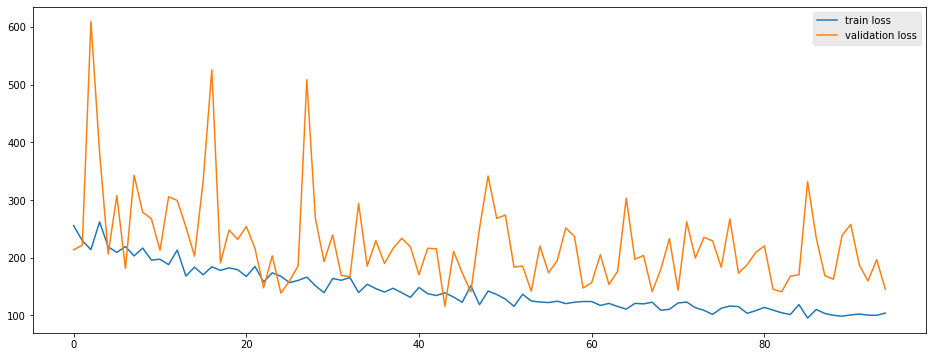

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
plt.plot(train_losses[5:],label='train loss')
plt.plot(val_losses[5:],label='validation loss')
plt.style.use('ggplot')
plt.legend()
plt.show()


In [ ]:
def prediction(x, y, batch_size = 32):
  name_of_pictures = x.copy()[:batch_size]
  data, labels, _ = CreateBatches(x_path = x, y_path = y, batch_size=32)

  data = tf.constant(np.array(data))

  labels = tf.constant(np.array(labels))

  predictions = model(data)

  return predictions.numpy(), name_of_pictures, labels

In [ ]:
from google.colab.patches import cv2_imshow

def visualize_prediction(image_path, index, prediction_coords, true_coords):

  coords_pred = []
  for i in range(0, len(prediction_coords) - 1, 2) :
    coords_pred.append([prediction_coords[i], prediction_coords[i+1]])

  coords_true = []
  for i in range(0, len(true_coords) - 1, 2) :
    coords_true.append([true_coords[i], true_coords[i+1]])

  coords_true = np.array(coords_true , dtype = np.int)
  coords_pred = np.array(coords_pred, dtype = np.int)



  img = cv2.imread(image_path[index])
  pred_rec1 = cv2.rectangle(img, (coords_pred[0,0] - 25, coords_pred[0,1]-70), (coords_pred[1,0] + 20, coords_pred[1,1]+45),(0,0,255),3)
  pred_rec2 = cv2.rectangle(img, (coords_pred[2,0] - 25, coords_pred[2,1]-70), (coords_pred[3,0] + 20, coords_pred[3,1]+45),(0,0,255),3)
  
  true_rec1 = cv2.rectangle(img, (coords_true[0,0] - 25, coords_true[0,1]-70), (coords_true[1,0] + 20, coords_true[1,1]+45),(0,255,0),3)
  true_rec2 = cv2.rectangle(img, (coords_true[2,0] - 25, coords_true[2,1]-70), (coords_true[3,0] + 20, coords_true[3,1]+45),(0,255,0),3)

  
  cv2_imshow(img)

In [ ]:
test_images_path_copy = test_images_path.copy()
test_labels_path_copy = test_labels_path.copy()

train_images_path_copy = train_images_path.copy()
train_labels_path_copy = train_labels_path.copy()

val_images_path_copy = val_images_path.copy()
val_labels_path_copy = val_labels_path.copy()

In [ ]:
predictions, picNames, y_true= prediction(test_images_path_copy, test_labels_path_copy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional inf

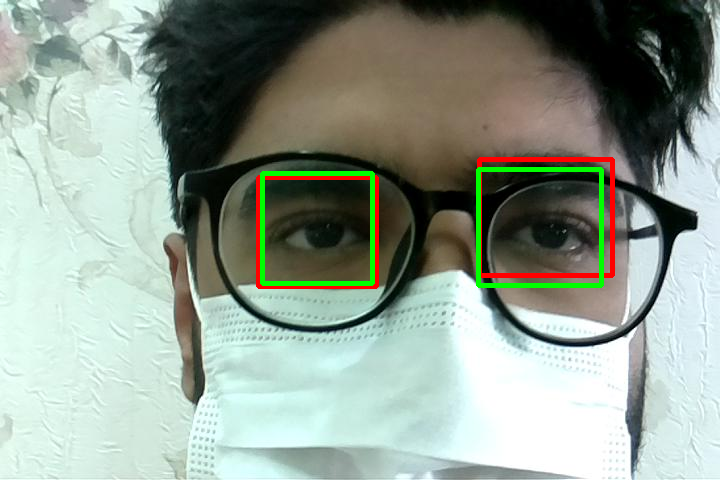

In [ ]:
visualize_prediction(picNames, 25, predictions[25], y_true[25])
#red rectangles are model predicitons
#green rectangles are Y_true